In [ ]:
import pandas as pd
import numpy as np
import datetime
from jax.api import vmap
import jax.numpy as jnp
import numpy.random as npr
from jax.api import jit, grad
from jax.tree_util import tree_multimap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [ ]:
!wget https://raw.githubusercontent.com/JSC370/jsc370.github.io/master/energy_dataset.csv
!wget https://raw.githubusercontent.com/JSC370/jsc370.github.io/master/weather_features.csv

In [ ]:
energy = pd.read_csv("energy_dataset.csv")
weather = pd.read_csv("weather_features.csv")

df_e = pd.DataFrame(energy)
df_w = pd.DataFrame(weather)

print("shape of energy data:", df_e.shape)
print("shape of weather data:", df_w.shape)

In [ ]:
############################################ Energy dataset ##########################################
# convert datetime string into timestamp 
df_e['time'] = df_e['time'].apply(lambda x : pd.to_datetime(str(x)))

# extracting date from timestamp
df_e['date'] = [datetime.datetime.date(d) for d in df_e['time']] 

# extracting time from timestamp
df_e['time'] = [datetime.datetime.time(d) for d in df_e['time']] 

############################################ Weather dataset ##########################################
# convert datetime string into timestamp 
df_w['dt_iso'] = df_w['dt_iso'].apply(lambda x : pd.to_datetime(str(x)))

# extracting date from timestamp
df_w['date'] = [datetime.datetime.date(d) for d in df_w['dt_iso']] 

# extracting time from timestamp
df_w['time'] = [datetime.datetime.time(d) for d in df_w['dt_iso']]

df_w = df_w.drop("dt_iso", axis=1) # dropping timestamp column

# changing order of columns for energy dataset
col_e = df_e.columns.tolist()
col_e = col_e[-1:] + col_e[:-1]
df_e = df_e[col_e]

# changing order of columns for weather dataset
col_w = df_w.columns.tolist()
col_w = col_w[-2:] + col_w[:-2]
df_w = df_w[col_w]

In [ ]:
# dropping columns with NaN and zero values
df_e = df_e.drop(["generation hydro pumped storage aggregated",
                  "forecast wind offshore eday ahead",
                  "generation fossil coal-derived gas",
                  "generation fossil oil shale",
                  "generation fossil peat",
                  "generation geothermal",
                  "generation marine",
                  "generation wind offshore"], axis=1)

# drop columns based on forecasts and prices
df_e = df_e.drop(["price actual",
                  "price day ahead",
                  "total load forecast",
                  "forecast wind onshore day ahead",
                  "forecast solar day ahead"], axis=1)

# dropping rows with NaN values.
# Note: It would be better to do this after making the Toeplitz matrix.
df_e = df_e.dropna(axis = 0)


# **Electric Load Prediction**

**Haiyue Yang, Yun Shen, Xin Peng**

The prediction of electric load is a task that can allow generators to decide how much production to ramp up, consumers to estimate electricity prices, and the grid operator to make sure enough transmission capacity is available. 

We are using 4-year electrical consumption, generation, pricing, and weather data for Spain from https://www.kaggle.com/nicholasjhana/energy-consumption-generation-prices-and-weather to build up time series models to predict future electric load using the previously observed values and features like weather.

And we have explored the data, brainstormed what factors could help improve the electric load prediction, proposed several models, and implemented the variants below.

# Add-on Value of the Data

* Help with planning future infrastructure. If the electricity is increasing gradually in a regeion, new plants might need to be constructed.
* Prepare extra energy supply if extreme weather happens. For example, the recent Texas outage resulted from the unexpected shutdown of generating plants. Extra energy supply and regular inspections could help prevent such outage from happening.
* Propose energy pricing strategies. The company could decide different prices for different times of the day due to the amount of electricity used and needed.
* Determine if new energy source is needed. When the demand exceeds the supply for a continuous time, more efficient energy source should be considered.


# Key Metrics to Measure Success

* Avoid energy breakdown in extreme weather. Public could track the number of outages happened in a year to see if the company has improved unexpected energy breakdown.
* Save of energy. Moreover, saving energy means saving the environment. With global warming, the company could utilize the prediction to generate the right amount of the energy to avoid any extra generation of energy.
* For our models, we used MSE as the metrics to determine the performance of the models. We also looked at whether the trend of predicted values fits the actual values on the plots to see if the model precisely predicts the electricity demand.


# Data Exploration

## Problems in the data

In [ ]:
df_e[['date', 'time']].groupby('date').count().sort_values('time').head()

,time
date,
2015-02-01,13
2015-01-05,17
2016-04-25,22
2015-10-02,22
2017-11-14,22


In the energy dataset, it is expected that the data of all 24 hours in a given day should be included. However, we discovered that for some given days, data in some hours is missing.

In [ ]:
df_e[df_e.date == datetime.date(2015, 2, 1)]

,date,time,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation nuclear,generation other,generation other renewable,generation solar,generation waste,generation wind onshore,total load actual
744,2015-02-01,00:00:00,433.0,323.0,4826.0,4883.0,169.0,498.0,1002.0,2408.0,7099.0,43.0,75.0,48.0,210.0,3360.0,24298.0
745,2015-02-01,01:00:00,445.0,316.0,4891.0,4676.0,187.0,1085.0,949.0,1204.0,7098.0,43.0,72.0,49.0,198.0,3088.0,21881.0
746,2015-02-01,02:00:00,441.0,320.0,4652.0,4693.0,180.0,1693.0,936.0,743.0,7099.0,43.0,72.0,48.0,194.0,3014.0,20495.0
747,2015-02-01,03:00:00,440.0,323.0,4603.0,4587.0,180.0,1934.0,930.0,636.0,7098.0,43.0,74.0,48.0,202.0,2821.0,19730.0
748,2015-02-01,04:00:00,432.0,310.0,4212.0,4597.0,177.0,1947.0,921.0,505.0,7100.0,44.0,74.0,47.0,209.0,2928.0,19500.0
749,2015-02-01,05:00:00,443.0,237.0,4215.0,4718.0,181.0,1898.0,928.0,545.0,7100.0,44.0,75.0,47.0,211.0,3119.0,20113.0
750,2015-02-01,06:00:00,435.0,282.0,4641.0,4934.0,188.0,1635.0,936.0,908.0,7101.0,44.0,74.0,47.0,210.0,3157.0,22153.0
754,2015-02-01,10:00:00,460.0,304.0,5393.0,5951.0,306.0,0.0,1179.0,5066.0,7098.0,43.0,73.0,1981.0,204.0,2272.0,32383.0
755,2015-02-01,11:00:00,450.0,317.0,4967.0,5997.0,318.0,0.0,1124.0,5357.0,7097.0,42.0,73.0,3082.0,205.0,1795.0,32358.0
764,2015-02-01,20:00:00,479.0,326.0,8036.0,6029.0,355.0,1.0,1329.0,7180.0,7096.0,42.0,82.0,124.0,209.0,1731.0,33955.0


For instance, in 2015-02-01, the data from 7am-9am and the data from 12pm - 19am are not included in the dataset.

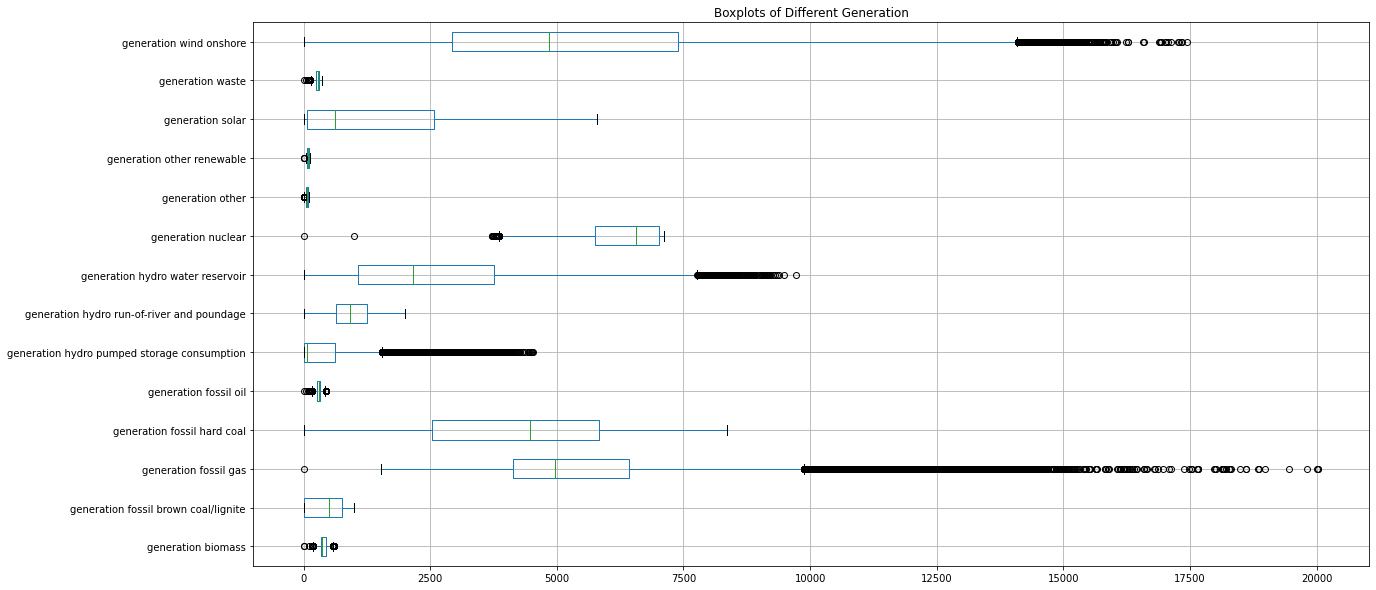

In [ ]:
import matplotlib.pyplot as plt 

plt.figure(figsize=(20,10))
plt.title('Boxplots of Different Generation')
df_e.loc[:, 'generation biomass':'generation wind onshore'].boxplot(vert=False)
plt.show()

We draw the boxplots of different ways of generations. We discovered that the generation of different ways varies a lot, wind onshore, nuclear, fossil hard coal and gossil gas tend to have more generations, with waste, fossil oil and biomass have less generations. 


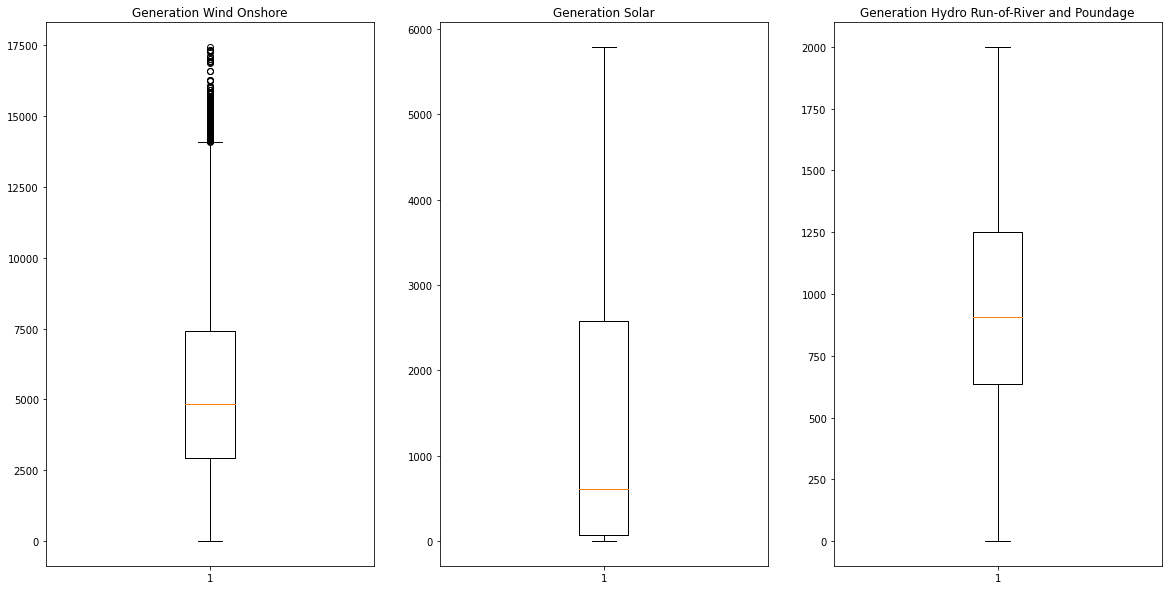

In [ ]:
plt.figure(figsize=(20,10))

plt.subplot(131)
plt.title("Generation Wind Onshore")
plt.boxplot(df_e['generation wind onshore'])

plt.subplot(132)
plt.title("Generation Solar")
plt.boxplot(df_e['generation solar'])

plt.subplot(133)
plt.title("Generation Hydro Run-of-River and Poundage")
plt.boxplot(df_e['generation hydro run-of-river and poundage'])

plt.show()

We take a deeper insight into the variable generations: wind onshore, solar, and hydro run of river and poundage. We discovered that among these three ways of generations, wind onshore has the largest variance, probably because the sun and run-of-river are comparatively stable with time, but wind is less predictable. 

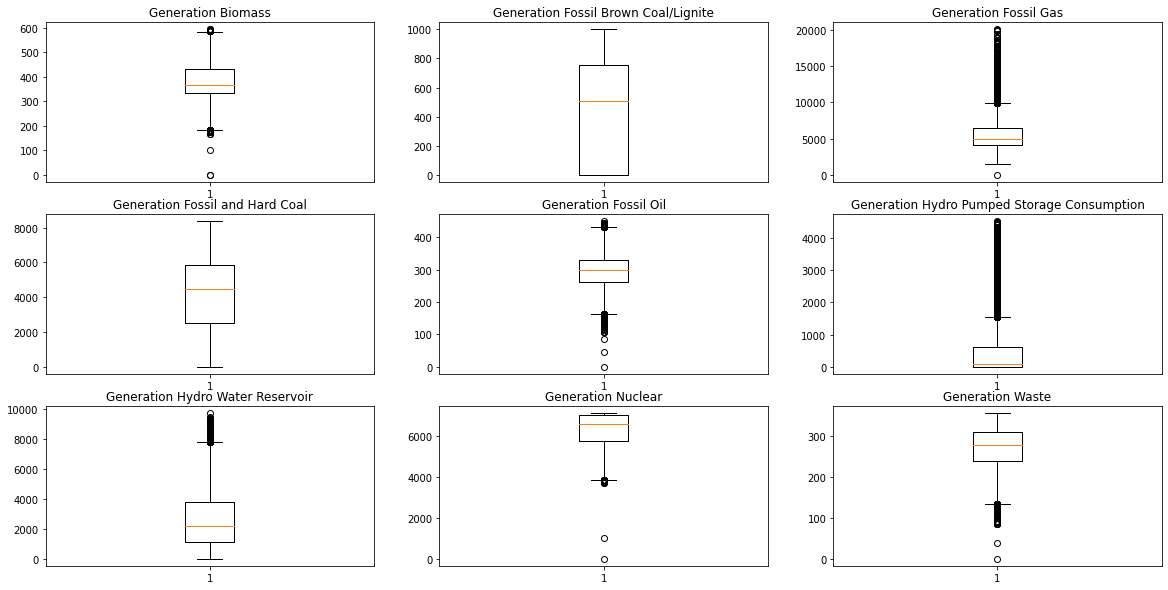

In [ ]:
plt.figure(figsize=(20,10))

plt.subplot(331)
plt.title("Generation Biomass")
plt.boxplot(df_e['generation biomass'])

plt.subplot(332)
plt.title("Generation Fossil Brown Coal/Lignite")
plt.boxplot(df_e['generation fossil brown coal/lignite'])

plt.subplot(333)
plt.title("Generation Fossil Gas")
plt.boxplot(df_e['generation fossil gas'])

plt.subplot(334)
plt.title("Generation Fossil and Hard Coal")
plt.boxplot(df_e['generation fossil hard coal'])

plt.subplot(335)
plt.title("Generation Fossil Oil")
plt.boxplot(df_e['generation fossil oil'])

plt.subplot(336)
plt.title("Generation Hydro Pumped Storage Consumption")
plt.boxplot(df_e['generation hydro pumped storage consumption'])

plt.subplot(337)
plt.title("Generation Hydro Water Reservoir")
plt.boxplot(df_e['generation hydro water reservoir'])

plt.subplot(338)
plt.title("Generation Nuclear")
plt.boxplot(df_e['generation nuclear'])

plt.subplot(339)
plt.title("Generation Waste")
plt.boxplot(df_e['generation waste'])

plt.show()

Then, we also look as fixed generations. Although these generation methods are considered to be fixed, some of them even have larger variance than the variable ones. I guess probably the variable generations are all clean energies and are used with a higher priority, and the fixed generations can be used as a complement to meet different demands. Especially the fixed generations that are relatively cheaper, like fossil gas, hydro pumped storage consumption, and hydro water reservoir, can be used to generate more when the demand is very high, so these three generations have outliers in the larger side. 



## Present trends and periodicity

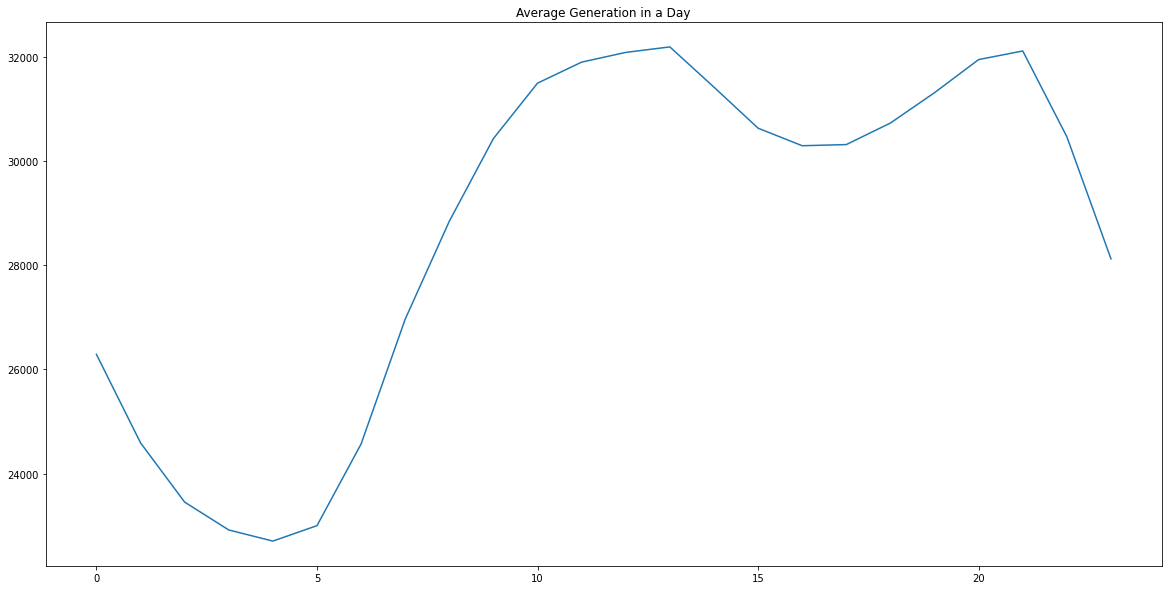

In [ ]:
time_e = df_e.groupby('time').mean().reset_index().reset_index()
plt.figure(figsize=(20, 10))
plt.title('Average Generation in a Day')
plt.plot(time_e['index'], time_e['total load actual'])
plt.show()

We investigated the periodic pattern of demand in different hours of a day. We discover that, on average, the demand is much higher during the daytime and is lower during the night. Moreover, the demand slightly drops in the afternoon, but increases again in the evening.


# Brainstorm a comprehensive list of factors that could affect the recorded data, or the trends your models will capture.

Before building up a model, it is important to notice that there are many factors that could conceivably influence the recorded electric load in real life. Here are some of these factors:



*   Holidays and special events.
*   Unusual times, like COVID-19 lockdown, there is dramatic reduction in electric use in services and industry,  however, demand is higher for residential use.
*   Technology improvement that decreases electricity use in industry.
*   Regulatory changes in using electricity, for example, time-of-use electricity rate, Tiered billing rate.
*   Policy change, for example, industrial transformation.
*   Price, for example, if the electricity price is high, consumers tend to use less electricity.
*   Day light savings.






# Complementary Sources of Data

Since there are many other factors that can affect the electric load. So to better make a prediction, we also need some complementary sources of data. 

*   Holiday date.
*   Special event record.
*   Day light savings date of each year.
*   Record of regulatory change in using electricity.
*   Reocrd of policy change that would affect electricity use like industrial transformation.

# Model Staircase

Here are some models we proposed.

*   Predict same demand as 24h ago (Baseline Model).
*   Autoregressive Model, and use previous 48 hours to predict next 24 hours.
*   Linear regression (Variant 1).
*   LSTM, and use previous 48 hours to predict next 24 hours (Variant 3 subvariant 1).
*   GRU, and use previous 48 hours to predict next 24 hours (Variant 3 subvariant 2).
*   Convert time series forcasting into a supervised learning problem and add weather feature to predict. (Variant 4)
*   Ensemble previous models. (Variant 5)

# Baseline Model

In the baseline model, we predict same demand as 24h ago. For example, we predict the electricity demand in 2018-12-31 23:00:00 to be the same as the electricity demand in 2018-12-30 23:00:00.

In [ ]:
df_e['previous_24_time'] = df_e['time']
df_e['previous_24_date'] = df_e['date'] + datetime.timedelta(days=-1)
df_baseline = df_e[['time','date', 'previous_24_time', 'previous_24_date', 'total load actual']]

df_baseline_merge = pd.merge(df_baseline, df_baseline,  how='right', left_on=['time','date'], right_on = ['previous_24_time','previous_24_date'])
df_baseline_merge = df_baseline_merge.rename(columns={"total load actual_y": "actual", "total load actual_x": "predicted"})
df_baseline_merge = df_baseline_merge[['time_y', 'date_y', 'actual', 'predicted']]

df_baseline_merge = df_baseline_merge.dropna()
baseline_predict = df_baseline_merge['predicted'][30000:]
baseline_actual = df_baseline_merge['actual'][30000:]

from sklearn.metrics import mean_squared_error
mean_squared_error(baseline_predict, baseline_actual)

12746358.793856103

By using the baseline model, we can see that MSE is 12746359, which is relatively large. And in the variants below, we will compare the testing MSE of the variants with the baseline MSE.

# Autoregressive Model

Autoregressive model is provided for us to predict electric load. Autoregressive model predicts future values based on past values, and in this autoregressive model, electric load of the previous 48 hours is used to predict the electic load of the next 24 hours. However, this model has assumed the linearity between previous observations and future observations. It also has some other limitations like not considering other features like weather, ignoring the covariance, etc. Also from the plot of "Prediction VS Actual Load Using Autoregressive", we can find that there still exists some problems in prediction as the prediction does not fit the actual value very well.

So in the next few variants, we will try some other models to do this time series prediction.

In [ ]:
# Allow an autoregressive model by turning the actual load series into Toeplitz
# matrix, by including copies of the last 48 hours of actual load.

history_interval_length = 48
predict_interval_length = 24
trim = history_interval_length + predict_interval_length

# For now, we'll just use load
load = df_e["total load actual"]

from scipy.linalg import toeplitz

tdata = toeplitz(load)[trim:-trim, :trim]  # Cut off ends with incomplete rows.
# The above operation is wasteful and uses tons of RAM.

tdata = np.fliplr(np.float32(np.array(tdata)))

X = tdata[:, :history_interval_length]
y = tdata[:, history_interval_length:]

In [ ]:
X_train = X[:30000, :]
y_train = y[:30000, :]
X_test = X[30000:, :]
y_test = y[30000:, :]

In [ ]:
alpha = 0.0000000005  # The learning rate
epochs = 1000  # The number of iterations to perform gradient descent

# weights and bias 
params = {
    'm': jnp.zeros([X_train.shape[1], y_train.shape[1]]),
    'c': jnp.zeros(y_train.shape[1:])
}

# linear regression 
def linear_reg(params, X):
    return jnp.dot(X, params['m']) + params['c']

# loss function (MSE error)
def loss(params, X, y):
    error = linear_reg(params, X) - y
    return jnp.mean(jnp.square(error))

#update parameters with gradient descent 
def update(params, X, y):
  grads = grad(loss)(params, X, y)
  return tree_multimap(lambda p, g: p - alpha * g, params, grads)

train_loss = [] # loss history

# main training loop
for i in range(epochs):
    params = update(params, X_train, y_train)
    train_error = loss(params, X_train, y_train)
    train_loss.append(train_error)
    test_error = loss(params, X_test, y_test)
    if i % 100 == 0:
      print(i,jnp.mean(train_error), jnp.mean(test_error))

0 368025730.0 380860670.0
100 13668292.0 13495825.0
200 11404723.0 11133426.0
300 10488203.0 10231205.0
400 10003367.0 9768374.0
500 9708450.0 9489148.0
600 9513156.0 9303581.0
700 9374784.0 9170876.0
800 9270716.0 9069912.0
900 9188280.0 8989001.0


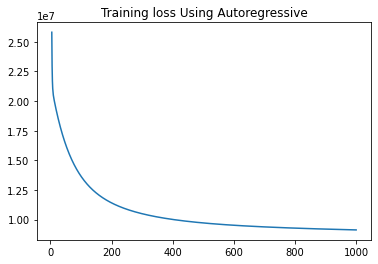

In [ ]:
iterations = range(epochs)
plt.plot(iterations[5:], train_loss[5:])
plt.title("Training loss Using Autoregressive")
plt.show()

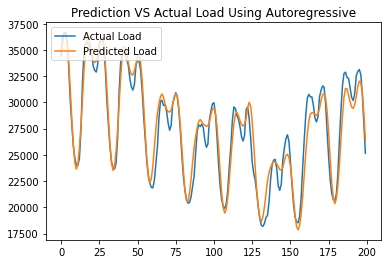

In [ ]:
true = y_test[-200:, 0]
pred = linear_reg(params, X_test)[-200:, 0]
plt.plot(true, label = "Actual Load")
plt.plot(pred, label = "Predicted Load")
plt.legend(loc="upper left")
plt.title("Prediction VS Actual Load Using Autoregressive")
plt.show()

In the above plot, we show the result of using previous 48 hours to predict a single next hour.

In [ ]:
from sklearn.metrics import mean_squared_error
mean_squared_error(linear_reg(params, X_test)[:, 0], y_test[:, 0])

2351017.8

The testing MSE of using autoregressive model is 2351017.8.

# Variant 1: Linear Regression

First, we would like to see if a simple linear regression model can satisfactorily predict the electric load. Our baseline model is an autogressive model, which is actually a linear regression model but using previous behaviours to predict future behaviours. However, we only used the "total load actual" data for the autoregressive model. In this linear regression model, we used the amount of electricity generatd by each methods to predict the total load.

We extracted all the variables regarding the amount of electricity generated from different methods and saved them in X. We saved the actual load as y. We then used a standard scaler to transform the data. We also split the data into train and test sets, and used the train set to fit a linear regression model.

In [ ]:
X = df_e.iloc[:,2:-1]
y = df_e.iloc[:,[-1]]

In [ ]:
from sklearn.preprocessing import StandardScaler
sc_x = StandardScaler()
X = sc_x.fit_transform(X)
X = pd.DataFrame(X)

In [ ]:
def TimeSeriesTrainTestSplit(x, y, test_size):
    
        test_index = int(len(X)*(1-test_size))
    
        X_train = X.iloc[:test_index]
        y_train = y.iloc[:test_index]
        X_test = X.iloc[test_index:]
        y_test = y.iloc[test_index:]
        return X_train, y_train, X_test, y_test
    
X_train, y_train, X_test, y_test = TimeSeriesTrainTestSplit(X,y, 0.2)

In [ ]:
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
y_pred = regressor.predict(X_test)

Text(0.5, 1.0, 'Prediction vs Actual Load (Linear Regression)')

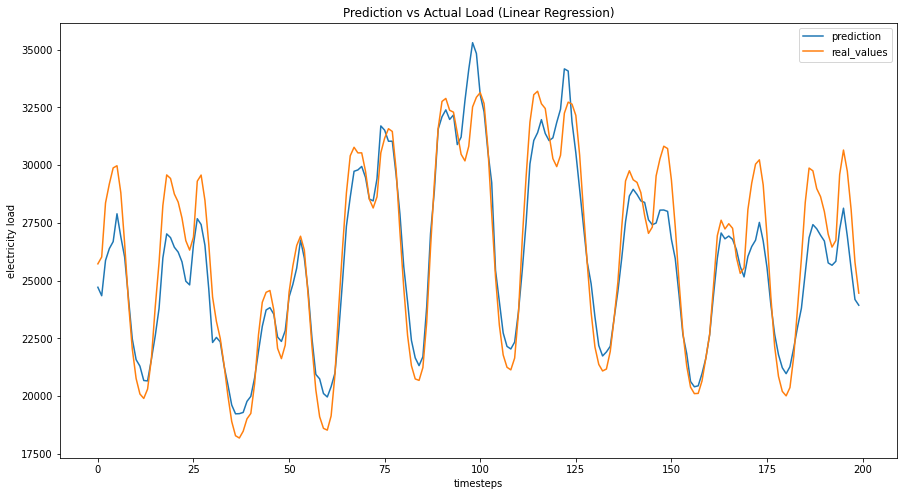

In [ ]:
plt.figure(figsize=(15,8))
plt.plot(regressor.predict(X_test[-200:]), label="prediction")
plt.plot(y_test.values[-200:], label="real_values")
plt.legend(loc="best")
plt.xlabel('timesteps')
plt.ylabel('electricity load')
plt.title("Prediction vs Actual Load (Linear Regression)")

From the plot, we saw that the performance of the linear regression model was not quite satisfactory. It preserved the ability to predict the peak and off-peak trend over the time, but the predicted values were far away from the actual values.

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
print('Test Mean Squared Error:', mean_squared_error(y_test, y_pred))
print('Test Mean Absolute Error:', mean_absolute_error(y_test, y_pred))

Test Mean Squared Error: 2157031.8485672977
Test Mean Absolute Error: 1160.3325599411407


The test MSE is around 2157031 and the test MAE is around 1160. Compared to the basedline model, which has a test MSE of 12746358, the test MSE decreased by around 83%. However, its test MSE was roughly the same as the autogressive model. This makes sense because the autoregressive model is basically a linear regression model using previous values to predict future values.

## Limitation
However, after we carefully looked over this approach again, we found that the total load is roughly the same as the sum of all the electricity generated by different methods. For the sake of this dataset, we want to predict future electricity demand so that the right amount of energy could be generated to avoid any waste of energy. Thus, this linear regression approach might not be very useful because it lacks the power of predict future demand from previous demand. We still included this method because we wanted it to serve as a new attempt to solve the problem with multi-variate data. This model also inspired us to merge the weatehr data.

# Variant 2: Neural Network

In this variant, we used a MLP Neural Network to predict the next 24 hours eletric load based on previous 48 hours electric load. Also we used the first 30000 data as training data, and the rest data as testing data.

Before training the model, we did some data preprocessing in this variant. We used data normalization using MinMaxScaler, so that variables lie in the range of 0 and 1. And we used the preproccessed data to train the model, and also used MSE as the loss function. Since the data is normalized and in the range of [0, 1], the training loss would be far smaller than the training loss in the autoregressive model, so we would not compare the training loss between Variant 2 and Autoregressive model here.

And we still used MSE as the loss function and Adam as the optimizer. And in the MLP, we used a single hidden layer with hidden size = 10, and ReLU on it.

In [ ]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler

In [ ]:
training_set = df_e.iloc[:,16:17].values

In [ ]:
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-24):
        _x = data[i:(i+seq_length)]
        _y = data[(i+seq_length):(i+seq_length+24)]
        x.append(_x)
        y.append(_y)
    return np.array(x),np.array(y)

sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 48
x, y = sliding_windows(training_data, seq_length)

train_size = 30000
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

In [ ]:
class MLP(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size):
        super(MLP, self).__init__()
        
        self.num_classes = num_classes
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        self.layers = nn.Sequential(
            nn.Linear(self.input_size, self.hidden_size),
            nn.ReLU(),
            nn.Linear(self.hidden_size, self.num_classes))

    def forward(self, x):
        
        output = self.layers(x)
        
        return output

In [ ]:
num_epochs = 1000
learning_rate = 0.01

input_size = 48
hidden_size = 10

num_classes = 24

mlp = MLP(num_classes, input_size, hidden_size)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(mlp.parameters(), lr=learning_rate)
training_loss_mlp = []
trainY = torch.squeeze(trainY)
trainXMLP = trainX[:, :, -1]

# Train the model
for epoch in range(num_epochs):
    outputs = mlp(trainXMLP)
    optimizer.zero_grad()
    # obtain the loss function
    loss = criterion(outputs, trainY)
    training_loss_mlp.append(loss)
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.34788
Epoch: 100, loss: 0.02924
Epoch: 200, loss: 0.02595
Epoch: 300, loss: 0.02077
Epoch: 400, loss: 0.01863
Epoch: 500, loss: 0.01835
Epoch: 600, loss: 0.01824
Epoch: 700, loss: 0.01817
Epoch: 800, loss: 0.01812
Epoch: 900, loss: 0.01811


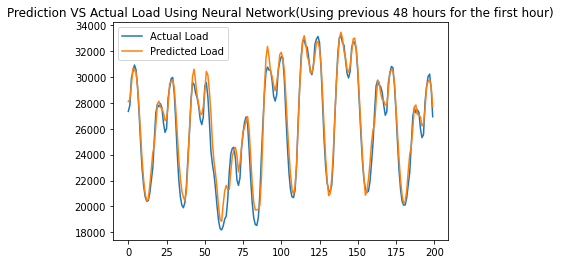

In [ ]:
x, y = sliding_windows(training_set, seq_length)
train_size = 30000
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

mlp.eval()
test_predict = mlp(testX[:, :, -1])

data_predict = test_predict.data.numpy()
dataY_plot = torch.squeeze(testY).data.numpy()

data_predict = sc.inverse_transform(data_predict)
data_predict = data_predict[-200:, 0]
dataY_plot = dataY_plot[-200:, 0]

plt.plot(dataY_plot, label="Actual Load")
plt.plot(data_predict, label="Predicted Load")
plt.legend(loc="upper left")
plt.title("Prediction VS Actual Load Using Neural Network(Using previous 48 hours for the first hour)")
plt.show()

In [ ]:
mlp.eval()
test_predict = mlp(testX[:, :, -1])
data_predict = test_predict.data.numpy()
x, y = sliding_windows(training_set, seq_length)
train_size = 30000
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))
dataY_plot = torch.squeeze(testY).data.numpy()
data_predict = sc.inverse_transform(data_predict)
data_predict_first = data_predict[:, 0]

from sklearn.metrics import mean_squared_error
testing_mse_mlp = mean_squared_error(data_predict_first, dataY_plot[:, 0])
testing_mse_mlp

919912.7

The performance of the Neural Network is quite good, and from the plot, we can see the first hour it predicts using the previous 48 hours is quite close to the actual demand, and it has greatly captured the trend and seasonality of this time series data.

Also using Neural Network can achieve testing MSE = 919913, which is only 7.2% of the MSE using baseline model, and even compared to using autoregressive model, neural network decreases testing MSE by 60.9%.

And although compared to the baseline model, using Neural Network is computationally expensive, but compared to RNN, the training time of this variant is fast enough.

# Variant 3: Recurrent Neural Network(LSTM and GRU)

RNN is a good way to deal with time series problems since it can retain state from one iteration to the next. However, it has some problems like gradient vanishing, not being able to capture long-term dependencies in a sequence. So in this variant, we used two RNN architectures, Long Short Term Memory and Gated Recurrent Units. GRU has two gates: reset gate and update gate and LSTM has two more gates: forget gate and output gate.




In both LSTM and GRU, we still used the previous 48 hours to predict the next 24 hours. Also we used the first 30000 data as training data, and the rest data as testing data. Again, we did data normalization using MinMaxScaler.


## Subvariant 1: LSTM
We used LSTM here, and used Adam optimizer, number of layers = 1, hidden size = 7.

In [ ]:
training_set = df_e.iloc[:,16:17].values

In [ ]:
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-24):
        _x = data[i:(i+seq_length)]
        _y = data[(i+seq_length):(i+seq_length+24)]
        x.append(_x)
        y.append(_y)
    return np.array(x),np.array(y)

sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 48
x, y = sliding_windows(training_data, seq_length)

train_size = 30000
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

In [ ]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        
        return out

In [ ]:
num_epochs = 1000
learning_rate = 0.01

input_size = 1
hidden_size = 7
num_layers = 1

num_classes = 24

lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

training_loss_lstm = []
trainY = torch.squeeze(trainY)

# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    # obtain the loss function
    loss = criterion(outputs, trainY)
    
    training_loss_lstm.append(loss)
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.26526
Epoch: 100, loss: 0.03666
Epoch: 200, loss: 0.03303
Epoch: 300, loss: 0.01849
Epoch: 400, loss: 0.01577
Epoch: 500, loss: 0.01434
Epoch: 600, loss: 0.01226
Epoch: 700, loss: 0.01159
Epoch: 800, loss: 0.01129
Epoch: 900, loss: 0.01111


In [ ]:
x, y = sliding_windows(training_set, seq_length)

In [ ]:
train_size = 30000
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

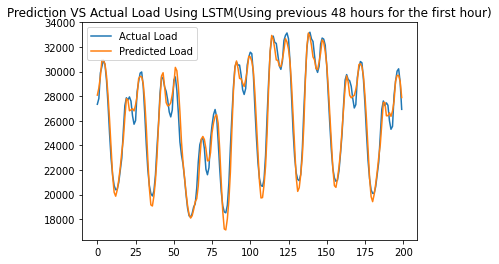

In [ ]:
lstm.eval()
test_predict = lstm(testX)

data_predict = test_predict.data.numpy()
dataY_plot = torch.squeeze(testY).data.numpy()

data_predict = sc.inverse_transform(data_predict)
data_predict = data_predict[-200:, 0]
dataY_plot = dataY_plot[-200:, 0]

plt.plot(dataY_plot, label="Actual Load")
plt.plot(data_predict, label="Predicted Load")
plt.legend(loc="upper left")
plt.title("Prediction VS Actual Load Using LSTM(Using previous 48 hours for the first hour)")
plt.show()

*Plot 1: The predicted first hour*

In [ ]:
lstm.eval()
test_predict = lstm(testX)
data_predict = test_predict.data.numpy()
x, y = sliding_windows(training_set, seq_length)
train_size = 30000
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))
dataY_plot = torch.squeeze(testY).data.numpy()
data_predict = sc.inverse_transform(data_predict)
data_predict_first = data_predict[:, 0]

from sklearn.metrics import mean_squared_error
testing_mse_lstm = mean_squared_error(data_predict_first, dataY_plot[:, 0])
testing_mse_lstm

839657.06

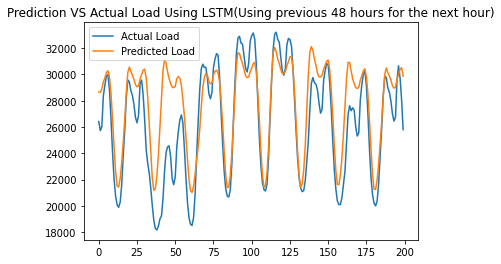

In [ ]:
data_predict = test_predict.data.numpy()
dataY_plot = torch.squeeze(testY).data.numpy()

data_predict = sc.inverse_transform(data_predict)
data_predict = data_predict[-200:, -1]
dataY_plot = dataY_plot[-200:, -1]

plt.plot(dataY_plot, label="Actual Load")
plt.plot(data_predict, label="Predicted Load")
plt.legend(loc="upper left")
plt.title("Prediction VS Actual Load Using LSTM")
plt.show()

*Plot 2: The predict 24th hour*

In variant 3, we still used previous 48 hours to predict next 24 hours, for example, we used t1, t2, t3, ..., t48 to predict t49, t50, ... t72. And from the above two plots, we can see that the predicted first hour (i.e., t49) is already quite close to the actual load (plot 1), however, the predicted 24th hour (i.e., t72) does not perform well (plot 2), and there is much difference in the predicted load and actual load. This is not surprising, since the first hour (i.e., t49) just used its previous 48 hours, while the 24th hour (i.e., t72) used data 24-hour before it, which cannot capture the trend very well.

And the testing MSE of using LSTM is 839657.06.

## Subvariant 2: GRU

We used GRU here, and used Adam optimizer, number of layers = 1, hidden size = .

In [ ]:
seq_length = 48
class GRUNet(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(GRUNet, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        h_out, _ = self.gru(x, h_0)
        
        h_out = h_out[:, -1, :]
        
        out = self.fc(h_out)
        
        return out

In [ ]:
num_epochs = 1000
learning_rate = 0.01

input_size = 1
hidden_size = 7
num_layers = 1

num_classes = 24

gru = GRUNet(num_classes, input_size, hidden_size, num_layers)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(gru.parameters(), lr=learning_rate)
training_loss_gru = []
trainY = torch.squeeze(trainY)

# Train the model
for epoch in range(num_epochs):
    outputs = gru(trainX)
    optimizer.zero_grad()
    
    # obtain the loss function
    loss = criterion(outputs, trainY)
    training_loss_gru.append(loss)
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.26963
Epoch: 100, loss: 0.03463
Epoch: 200, loss: 0.02257
Epoch: 300, loss: 0.01726
Epoch: 400, loss: 0.01398
Epoch: 500, loss: 0.01290
Epoch: 600, loss: 0.01249
Epoch: 700, loss: 0.01225
Epoch: 800, loss: 0.01201
Epoch: 900, loss: 0.01182


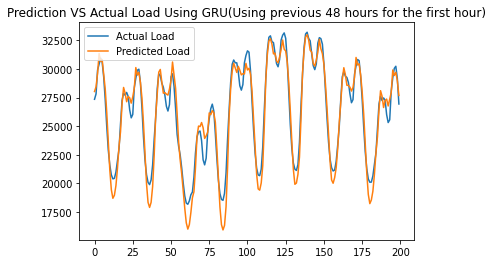

In [ ]:
x, y = sliding_windows(training_set, seq_length)
train_size = 30000
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

gru.eval()
test_predict = gru(testX)

data_predict = test_predict.data.numpy()
dataY_plot = torch.squeeze(testY).data.numpy()

data_predict = sc.inverse_transform(data_predict)
data_predict = data_predict[-200:, 0]
dataY_plot = dataY_plot[-200:, 0]

plt.plot(dataY_plot, label="Actual Load")
plt.plot(data_predict, label="Predicted Load")
plt.legend(loc="upper left")
plt.title("Prediction VS Actual Load Using GRU(Using previous 48 hours for the first hour)")
plt.show()

In [ ]:
gru.eval()
test_predict = gru(testX)
data_predict = test_predict.data.numpy()
x, y = sliding_windows(training_set, seq_length)
train_size = 30000
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))
dataY_plot = torch.squeeze(testY).data.numpy()
data_predict = sc.inverse_transform(data_predict)
data_predict_first = data_predict[:, 0]

from sklearn.metrics import mean_squared_error
testing_mse_gru = mean_squared_error(data_predict_first, dataY_plot[:, 0])
testing_mse_gru

878779.7

The performance of using GRU is good, but compared to using LSTM, it fails to capture some trend, especially during off-peak hours, it always predicts demand lower than actual demand. And the testing MSE of using GRU is 878779.7, which is also a little higher than using LSTM.

## Variant 3 Summary

\begin{array}{ccc}
&Testing MSE\\
BaselineModel& 12746359 \\
Autoregressive Model& 2351018\\
LSTM& 839657\\
GRU& 878780
\end{array}

Using LSTM and GRU has all greatly improved the performance of predicting electricity demand, and lowered the testing MSE. Compared to GRU, LSTM performs slightly better, and has a slightly lower testing MSE. And using LSTM has decreased the testing MSE by 93.4% compared to the baseline model, and decreased the testing MSE by 64.2% compared to using autoregressive model.

## Variant 3 Limitation

However, there still exists some limitations for using variant 3. First, it does not take other features like weather or special event into consideration. So if the weather is extreme in some day, variant 3 will still use the previous 48 hours to predict as usual, and fail to consider the extra electric load in the extreme weather.

Also, both GRU and LSTM did not capture the trend very well during off-peak hours, and they would predict demand lower than actual demand during off-peak hours.

And for a more general case of time series prediction, if the data is non-stationary and prone to change, for example, financial data, RNN is not a good way to predict data in this senario.

# Variant 4: Weather Feature

In this variant, we transform the time series forecasting problem into a supervised learning problem. That is, we use the sliding window of the demands in the previous 48 hours as features to predict current demand. 

In addition to the previous 48 hours demand, we also add the weather features: average temperature, pressure, humidity, and wind_speed to the model and conduct a linear regression.

In [ ]:
weather = df_w[['date', 'time', 'temp', 'pressure', 'humidity', 'wind_speed']].groupby(['date', 'time']).mean().reset_index()
generation = df_e[['date', 'time', 'total load actual']]

In [ ]:
df = pd.merge(generation, weather, how = "inner", on = ['date', 'time'])

In [ ]:
df = df.groupby(['date', 'time']).mean().reset_index()

In [ ]:
df['previous'] = None
for i in range(24, len(df['total load actual'])):
  df['previous'][i] = df['total load actual'][i-24:i].values

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
for j in range(24):
  s = 'previous' + str(j)
  df[s] = None
for i in range(24, len(df)):
  for j in range(24):
    s = 'previous' + str(j)
    df[s][i] = df['previous'][i][j]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [ ]:
training = df.iloc[24:30000]
testing = df.iloc[30000:]

In [ ]:
testing['datetime'] = 0
for i in testing.index:
  testing['datetime'][i] = datetime.datetime.combine(testing['date'][i], testing['time'][i])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:1060: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.or

In [ ]:
X_train_1 = training.iloc[:, 3:]
Y_train_1 = training.iloc[:, 2]
X_test_1 = testing.iloc[:, 3:-1]
Y_test_1 = testing.iloc[:, 2]

In [ ]:
X_train_1.drop(columns = ['previous'], inplace = True)
X_test_1.drop(columns = ['previous'], inplace = True)

In [ ]:
from sklearn.linear_model import LinearRegression
model1=LinearRegression(normalize = True)
model1.fit(X_train_1,Y_train_1)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [ ]:
model1.score(X_test_1, Y_test_1)

0.9763935736037983

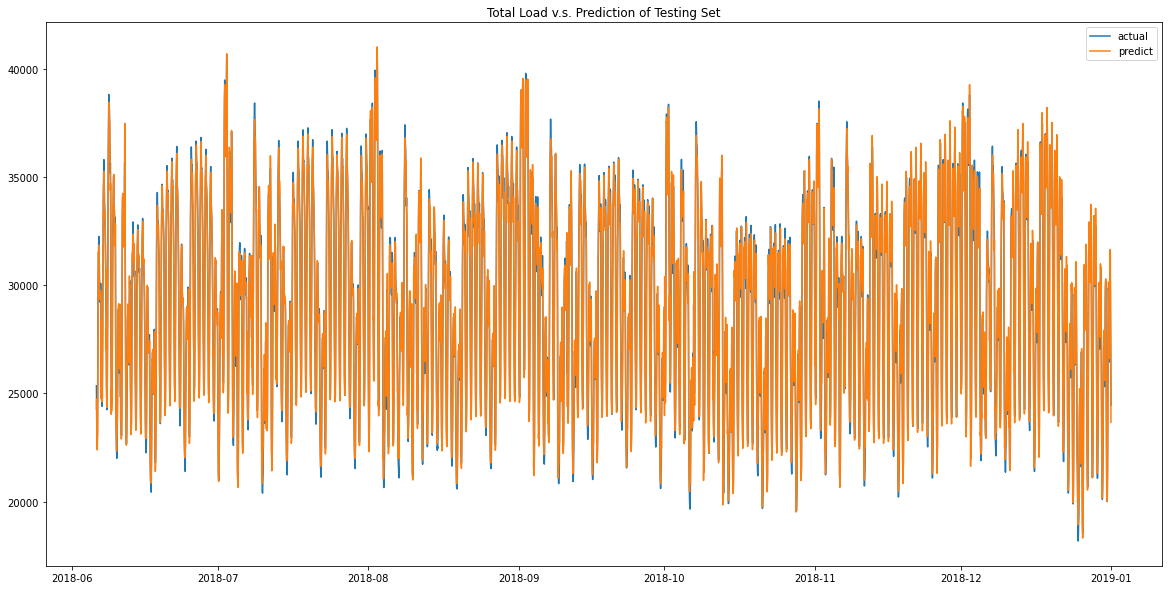

In [ ]:
plt.figure(figsize = (20, 10))
plt.title("Total Load v.s. Prediction of Testing Set")
plt.plot(testing['datetime'], testing['total load actual'], label = "actual")
plt.plot(testing['datetime'], model1.predict(X_test_1), label = "predict")
plt.legend()
plt.show()

From the graph and data above, the result of this variant is satisifying, with a score of 0.9763935736037983 on the testing set, which means the model has captured most variation in the demand of energy.

# Variant 5: Ensemble

In this variant, we use bagging to ensemble the autoregressive model and the neural network model. For each of the two model, we resampled 30000 observations with replacement from the originl training set to train the model and predict. Then, we take the average of the two predictions as the final prediction of the ensembled model. 

## Model 1: Neural Network

In [ ]:
training_set = df_e.iloc[:,16:17].values
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-24):
        _x = data[i:(i+seq_length)]
        _y = data[(i+seq_length):(i+seq_length+24)]
        x.append(_x)
        y.append(_y)
    return np.array(x),np.array(y)

# sc = MinMaxScaler()
# training_data = sc.fit_transform(training_set)

seq_length = 48
x, y = sliding_windows(training_set, seq_length)

train_size = 30000
test_size = len(y) - train_size

x = x[:, :, -1]
y = y[:, :, -1]

In [ ]:
indices = np.random.choice(x.shape[0], 30000, replace=False)
sample_x_mlp = x[indices]
sample_y_mlp = y[indices]

In [ ]:
trainX = Variable(torch.Tensor(np.array(sample_x_mlp)))
trainY = Variable(torch.Tensor(np.array(sample_y_mlp)))

In [ ]:
num_epochs = 1200
learning_rate = 0.01

input_size = 48
hidden_size = 10

num_classes = 24

mlp = MLP(num_classes, input_size, hidden_size)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(mlp.parameters(), lr=learning_rate)
training_loss_mlp = []
trainXMLP = trainX

# Train the model
for epoch in range(num_epochs):
    outputs = mlp(trainXMLP)
    optimizer.zero_grad()
    # obtain the loss function
    loss = criterion(outputs, trainY)
    training_loss_mlp.append(loss)
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 893804864.00000
Epoch: 100, loss: 20391010.00000
Epoch: 200, loss: 19574238.00000
Epoch: 300, loss: 18942746.00000
Epoch: 400, loss: 18077172.00000
Epoch: 500, loss: 17077756.00000
Epoch: 600, loss: 16280303.00000
Epoch: 700, loss: 15738405.00000
Epoch: 800, loss: 15408188.00000
Epoch: 900, loss: 15227831.00000
Epoch: 1000, loss: 15136685.00000
Epoch: 1100, loss: 15091161.00000


In [ ]:
# Allow an autoregressive model by turning the actual load series into Toeplitz
# matrix, by including copies of the last 48 hours of actual load.

history_interval_length = 48
predict_interval_length = 24
trim = history_interval_length + predict_interval_length

# For now, we'll just use load
load = df_e["total load actual"]

from scipy.linalg import toeplitz

tdata = toeplitz(load)[trim:-trim, :trim]  # Cut off ends with incomplete rows.
# The above operation is wasteful and uses tons of RAM.

tdata = np.fliplr(np.float32(np.array(tdata)))

X = tdata[:, :history_interval_length]
y = tdata[:, history_interval_length:]

In [ ]:
X_train = X[:30000, :]
y_train = y[:30000, :]
X_test = X[30000:, :]
y_test = y[30000:, :]

In [ ]:
mlp.eval()
X_test = torch.Tensor(np.positive(X_test))

In [ ]:
test_predict = mlp(X_test)

data_predict = test_predict.data.numpy()
data_predict = data_predict[:, 0]

## Model 2: Autoregressive

In [ ]:
# Allow an autoregressive model by turning the actual load series into Toeplitz
# matrix, by including copies of the last 48 hours of actual load.

history_interval_length = 48
predict_interval_length = 24
trim = history_interval_length + predict_interval_length

# For now, we'll just use load
load = df_e["total load actual"]

from scipy.linalg import toeplitz

tdata = toeplitz(load)[trim:-trim, :trim]  # Cut off ends with incomplete rows.
# The above operation is wasteful and uses tons of RAM.

tdata = np.fliplr(np.float32(np.array(tdata)))

X = tdata[:, :history_interval_length]
y = tdata[:, history_interval_length:]

In [ ]:
X_train = X[:30000, :]
y_train = y[:30000, :]
X_test = X[30000:, :]
y_test = y[30000:, :]

In [ ]:
alpha = 0.0000000005  # The learning rate
epochs = 1000  # The number of iterations to perform gradient descent

# weights and bias 
params = {
    'm': jnp.zeros([X_train.shape[1], y_train.shape[1]]),
    'c': jnp.zeros(y_train.shape[1:])
}

# linear regression 
def linear_reg(params, X):
    return jnp.dot(X, params['m']) + params['c']

# loss function (MSE error)
def loss(params, X, y):
    error = linear_reg(params, X) - y
    return jnp.mean(jnp.square(error))

#update parameters with gradient descent 
def update(params, X, y):
  grads = grad(loss)(params, X, y)
  return tree_multimap(lambda p, g: p - alpha * g, params, grads)

train_loss = [] # loss history

# main training loop
for i in range(epochs):
    params = update(params, X_train, y_train)
    train_error = loss(params, X_train, y_train)
    train_loss.append(train_error)
    test_error = loss(params, X_test, y_test)
    if i % 100 == 0:
      print(i,jnp.mean(train_error), jnp.mean(test_error))

0 368025730.0 380860600.0
100 13668292.0 13495824.0
200 11404721.0 11133426.0
300 10488205.0 10231205.0
400 10003368.0 9768374.0
500 9708450.0 9489148.0
600 9513155.0 9303582.0
700 9374783.0 9170877.0
800 9270715.0 9069912.0
900 9188280.0 8989001.0


In [ ]:
pred = linear_reg(params, X_test)[:, 0]

## Ensemble

In [ ]:
predict = (data_predict + pred) / 2

In [ ]:
y_test

array([[30923., 28894., 28642., ..., 35882., 35170., 35640.],
       [28894., 28642., 26657., ..., 35170., 35640., 34910.],
       [28642., 26657., 25303., ..., 35640., 34910., 32677.],
       ...,
       [30753., 27882., 25147., ..., 32728., 32642., 32155.],
       [27882., 25147., 23068., ..., 32642., 32155., 30428.],
       [25147., 23068., 21779., ..., 32155., 30428., 28015.]],
      dtype=float32)

In [ ]:
from sklearn.metrics import mean_squared_error
testing_mse_ensemble = mean_squared_error(predict, y_test[:, 0])
testing_mse_ensemble

4351404.0

In the ensembled model, the testing MSE is 4351404, which is lower than the MSE of the autoregressive model but higher than the MSE of the neural network. 

Probably because the performance of the autoregressive model is much worse than the nerual network, ensembling this two model is a large improvement to the autoregressive model, but cannot improve the performance of the nerual netwokr.